## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.



<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df= pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
len(df[(df['group']=="treatment")&(df['landing_page'] !="new_page")])

1965

f. Do any of the rows have missing values?

In [7]:
#NO missing values are seen
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
#I will remove these non matching rows based on the quiz provided
dftest =df[~((df['group'] =="control" )& (df['landing_page']=="new_page"))]
df2=dftest[~((df['group']=="treatment") &(df['landing_page']== "old_page"))]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [33]:
df2.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.duplicated(subset="user_id")]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

The repeat user id is 773192 as seen above.

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [12]:
df2=df2.drop_duplicates(subset="user_id", keep="first")

In [34]:
#Verify that the duplicate user_id was removed
df2.user_id.count()

290584

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
control_converted_prop =df2.query('group=="control"')['converted'].mean()
control_converted_prop

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
treatment_converted_prop=(df2.query('group=="treatment"')['converted']).mean()
treatment_converted_prop

0.11880806551510564

Find the observed difference in the proportions 

In [17]:
obs_diff = treatment_converted_prop - control_converted_prop
obs_diff

-0.0015782389853555567

d. What is the probability that an individual received the new page?

In [18]:
s=(df2['landing_page']=="new_page").sum()
s/len(df2)

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**There is no sufficient evidence that the new page leads to more conversions because of the half of the users that received the new page only 11.8% got converted which is actually a little less than the users who got the old page and got converted,this proportion being 12%. This difference in the observed statistic is seen as -0.0015782389853555567 .**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**H0 : Pnew - Pold <=0           

  HA : Pnew -Pold >0 **

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

 Pnew =  0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

Since Pnew = Pold under the null, the Pnew =Pold=  0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [19]:
#nnew= 145310
df2[df2['group']=="treatment"].count()


user_id         145310
timestamp       145310
group           145310
landing_page    145310
converted       145310
dtype: int64

d. What is $n_{old}$, the number of individuals in the control group?

In [21]:
#nold = 145274
df2[df2['group']=="control"].count()


user_id         145274
timestamp       145274
group           145274
landing_page    145274
converted       145274
dtype: int64

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [36]:
pold=  0.11959708724499628
pnew = 0.11959708724499628

In [37]:
#Below is just one test or one trial of 145310 transactions
new_page_converted= np.random.choice([0,1], size=145310,p =[1-pnew, pnew])

In [38]:
new_page_converted.mean() 


0.12043906131718395

In [ ]:
#Simulated nold transactions with pold 

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [39]:
old_page_converted= np.random.choice([0,1],145274,p =[1-pold, pold])

In [40]:
old_page_converted.mean()

0.11949832729875959

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [41]:
#pnew-pold
0.12043906131718395  - 0.11949832729875959


0.0009407340184243579

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [24]:
n_old= 145274
n_new= 145310
p_new=p_old=0.11959708724499628

In [ ]:
#REPLACED THIS PART AS SEEN BELOW
#The kernel takes less time for small number of simulations e.g. 100
#p_diffs=[]
#for _ in range(10000):
   # new_page_converted= df2.sample(145310, replace= True)
    #Pnew =new_page_converted.query('group=="treatment"')['converted'].mean()
    #old_page_converted= df2.sample(145274, replace= True) 
    #Pold= old_page_converted.query('group=="control"')['converted'].mean()
    #p_diffs.append(Pnew-Pold)
    
     

In [ ]:
        
##Replaced the above loop with the random.binomial function below for faster computation      

In [25]:
# The random .binomial generates the number of successes ~ converted
p_diffs=[]
new_convert_simulation= np.random.binomial(n_new, p_new,  10000)/n_new
old_convert_simulation= np.random.binomial(n_old,  p_old, 10000)/n_old
p_diffs = new_convert_simulation - old_convert_simulation

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

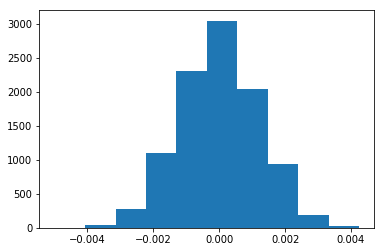

In [26]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

To answer the question j, we do the following

In [27]:
#Simulate the normal distribution of the difference in proportions 
p_diffs = np.array(p_diffs)
null_vals= np.random.normal(0, p_diffs.std(),p_diffs.size)

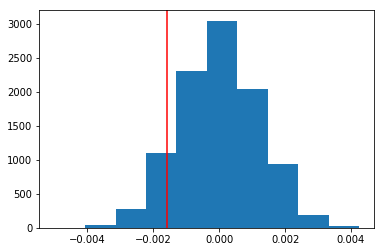

In [28]:
plt.hist(p_diffs);
plt.axvline(x=obs_diff, color="red")


In [29]:
(null_vals>=obs_diff).mean()# so we should not ignore the null.

0.90369999999999995

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

The value computed in part j is the probability of seeing a statistic( here difference in proportions) as extreme as our sample statistic here assuming the null hypothesis is true.
This is the p value and it is 0.097 we got here; which is greater than the common threshold of 0.05 which suggests that we cannot ignore the null hypothesis and that our test statistic came from this null distribution. That is, our null hypothesis that the new pages are as good as the old pages , so no statistical significance is observed in the conversions with the treatment of new pages.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [30]:
import statsmodels.api as sm
#CORRECTED THIS PART 
convert_old = (df2.query('group=="control"')['converted']==1).sum()
convert_new = (df2.query('group=="treatment"')['converted']==1).sum()
n_old = 145274
n_new = 145310

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [42]:
convert_old

17489

In [43]:
convert_new

17264

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [31]:
#from statsmodels.stats.proportion import proportions_ztest
zscore, pvalue= sm.stats.proportions_ztest([convert_new, convert_old],[n_new, n_old], alternative='larger')

In [32]:
zscore, pvalue

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The test statistic is z standard deviations away from the mean proportions in the null.
The zscore I found is -1.31 and the pvalue is 0.905 which agrees with the p value found in part j where we found it by the process of simulation.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Here I will use the Logistic regression since the response variable is a categorial type of "yes" or "no" as well as the explanatory variable is also categorical; the treatment or control.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [45]:
df2['intercept'] =1

In [46]:
#Keep old_page the base line model 
df2[['new_page', 'old_page']]=pd.get_dummies(df2['landing_page'])

In [47]:
#drop oldpage to keep it as a baseline to compare with
df2= df2.drop('old_page', axis=1)


In [48]:
#Verify
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [49]:
#Rename new_page as ab_page
df2.rename(columns={'new_page':'ab_page'}, inplace =True)

In [50]:
#create dummy variable for the response variable 'converted' 
df2[['zero','convert_yes']]=pd.get_dummies(df2['converted'])

In [51]:
df2=df2.drop('zero', axis = 1)

c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [52]:
#drop control column when fitting 
mod= sm.Logit(df2['convert_yes'], df2[['intercept','ab_page']])

In [53]:
res=mod.fit()

Optimization terminated successfully.
         Current function value: 448.424145
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [54]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            convert_yes   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 26 May 2019   Pseudo R-squ.:              -1.405e-05
Time:                        03:19:25   Log-Likelihood:            -1.3030e+08
converged:                       True   LL-Null:                   -1.3030e+08
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [55]:
# Find 1 over the exponential logodds for coefficients less than 1
1/np.exp(-0.0150)

1.0151130646157189

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**The p value associated with ab_page is 0.190 is close to the p value found in the part II -J and K which is 0.905. In the PART 2 our null hypothesis was that the new page is as good as or less better than the old page in terms of converting the user. Here in PART 3 our null hypothesis is that Pold =Pnew. The alternate HA: Pold notEq Pnew And that value here is 0.190 which indicates that the new page may not be a good predictor for the conversions. Given that part2 is a one sided test and part 3 is a two sided test, we can eaily convert one sided p value to a two sided p value or vice a versa.
So then let us verify if the p value in part2 0.905 can be converted to the two sided value in part 3 we got.
Since our Ha is testing the positive direction we do,
1- 0.905 =0.095
2 * 0.095 =0.19  which is equal to the p vale we found in part 3**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**We want to add more than one factor to our regression analysis to understand the impact of multiple variables on the conversion. There are some disadvantages to using multiple variables when the variables are correlated meaning they are not independent of each other. When one changes, the other changes with it and will be difficult to model the relationship of each independent variable with the dependent variable independently. This is called as the problem of multicollinearity.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [56]:
df_country= pd.read_csv('countries.csv')

In [57]:
#Merge with the df2 dataframe
df2= df2.set_index('user_id').join(df_country.set_index('user_id'))

In [58]:
df2.country.unique()

array(['US', 'CA', 'UK'], dtype=object)

In [60]:
#Create dummy for country
df2[['CA','UK','US']]=pd.get_dummies(df2.country)

In [61]:
#DROP the US column to keep it as a base line to compare
df2= df2.drop('US', axis =1)

In [62]:
df2.head()

,timestamp,group,landing_page,converted,intercept,ab_page,convert_yes,country,CA,UK
user_id,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,US,0,0
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0,US,0,0
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,US,0,0
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,US,0,0
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,US,0,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [63]:
#Carry out the logistic regression using teh country and type of page 
model= sm.Logit(df2['convert_yes'], df2[['intercept','ab_page','CA','UK']])

In [64]:
#Now fit the model
results= model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 448.436079
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            convert_yes   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 26 May 2019   Pseudo R-squ.:              -4.067e-05
Time:                        03:20:17   Log-Likelihood:            -1.3031e+08
converged:                       True   LL-Null:                   -1.3030e+08
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [65]:
#Finding the exponential of logodds to interprete the coefficients 
1/np.exp(-0.0149), 1/np.exp(-0.0408),np.exp(0.0099), 1/np.exp(-1.9893)

(1.0150115583846535, 1.0416437559600236, 1.0099491671175422, 7.310414680563591)

# CONCLUSION

In the first part of the analyses, we tested the hypothesis that the new pages will lead to more conversions than the old pages. Here we saw that the probability of seeing the difference in the percentage of conversions was higher under the assumption that the old pages are better; so we cannot deny that the old pages are better than the new pages in terms of converting a user and that the addition of the new pages did not really make any difference.
In the second part,we added another factor the country the user was in, in addition to the kind of page the user received.We find that the users from the US are 7.31 times as likely to get converted. The users from the Canada are 1.041 times as likely to get converted compared to the US users regardless of what page they received. Similarly the users from the UK are 1.0099 times as likely to get converted as compared to the US users keeping all other factors constant. So the highest number of users getting converted are from the US.
From the above we see that adding the country to the model does not affect the conversions associated with the kind of page the user received. 

In [66]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0